In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import tensorflow as tf
import sys
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pickle
from statsmodels.regression.quantile_regression import QuantReg

In [2]:
data = pickle.load(open("../data/SF.pickle", "rb"))

In [3]:
dataset = 5
timediff = data[dataset]["timediff"]
magdiff = data[dataset]["magdiff"]
d = {'timediff': timediff, 'magdiff': magdiff}
data = pd.DataFrame(data=d)
mod = smf.quantreg('magdiff ~ timediff', data)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                magdiff   Pseudo R-squared:              0.01944
Model:                       QuantReg   Bandwidth:                     0.05026
Method:                 Least Squares   Sparsity:                        1.020
Date:                Sun, 01 Apr 2018   No. Observations:                68578
Time:                        18:44:43   Df Residuals:                    68576
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4547      0.003   -135.634      0.000      -0.461      -0.448
timediff       0.0001   2.75e-06     44.716      0.000       0.000       0.000

The condition number is large, 2.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [4]:
quantiles = np.arange(.05, .96, .1)
def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['timediff']] + \
            res.conf_int().ix['timediff'].tolist()
models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b','lb','ub'])
ols = smf.ols('magdiff ~ timediff', data).fit()
ols_ci = ols.conf_int().ix['timediff'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['timediff'],
           lb = ols_ci[0],
           ub = ols_ci[1])
print(models)
print(ols)


      q         a         b        lb        ub
0  0.05 -1.426249  0.000097  0.000082  0.000113
1  0.15 -0.999689  0.000113  0.000102  0.000123
2  0.25 -0.773121  0.000113  0.000104  0.000121
3  0.35 -0.624958  0.000119  0.000112  0.000126
4  0.45 -0.508023  0.000123  0.000117  0.000129
5  0.55 -0.405303  0.000123  0.000118  0.000128
6  0.65 -0.310958  0.000123  0.000118  0.000127
7  0.75 -0.217709  0.000124  0.000119  0.000128
8  0.85 -0.109794  0.000123  0.000119  0.000128
9  0.95  0.078928  0.000101  0.000095  0.000106
{'a': -0.53505407197684329, 'b': 0.00011441794199402858, 'ub': 0.00011927946112771916, 'lb': 0.000109556422860338}


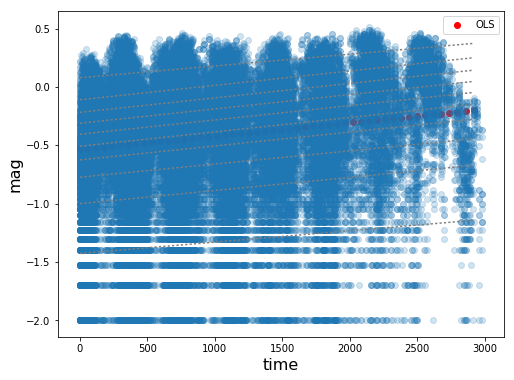

In [5]:
x = np.arange(timediff.min(), timediff.max(), (timediff.max() - timediff.min())/50)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', color='grey')
    
y = get_y(ols['a'], ols['b'])

ax.scatter(x, y, color='red', label='OLS')
ax.scatter(timediff, magdiff, alpha=.2)
# ax.set_xlim((240, 3000))
# ax.set_ylim((240, 2000))
legend = ax.legend()
ax.set_xlabel('time', fontsize=16)
ax.set_ylabel('mag', fontsize=16);

In [7]:
# plt.plot(models.q, models.b, color='black', label='Quantile Reg.')
# plt.plot(models.q, models.ub, linestyle='dotted', color='black')
# plt.plot(models.q, models.lb, linestyle='dotted', color='black')
# plt.hold(True)
# plt.scatter(timediff, magdiff, alpha=.2)

In [16]:
def helper(timediff, magdiff, quantiles):
    d = {'timediff': timediff, 'magdiff': magdiff}
    data = pd.DataFrame(data=d)
    mod = smf.quantreg('magdiff ~ timediff', data)
    res = mod.fit(q=.5)
    
    def fit_model(q):
        res = mod.fit(q=q)
        return [q, res.params['Intercept'], res.params['timediff']] + \
                res.conf_int().ix['timediff'].tolist()

        
    models = [fit_model(x) for x in quantiles]
    models = pd.DataFrame(models, columns=['q', 'a', 'b','lb','ub'])
    ols = smf.ols('magdiff ~ timediff', data).fit()
    ols_ci = ols.conf_int().ix['timediff'].tolist()
    ols = dict(a = ols.params['Intercept'],
               b = ols.params['timediff'],
               lb = ols_ci[0],
               ub = ols_ci[1])
    
    
    x = np.arange(timediff.min(), timediff.max(), (timediff.max() - timediff.min())/50)
    get_y = lambda a, b: a + b * x

    subArray = np.zeros((len(quantiles), 2))
    for i in range(models.shape[0]):
        y = get_y(models.a[i], models.b[i])
        subArray[i][0] = models.a[i]
        subArray[i][1] = models.b[1]

    return subArray
    
# array of len(quantiles) by 2 * split_into, with 2i'th index as intercept and 2i+1'th index as slope for 0 <= i < split_into
def helper_split_10(subdata, split_into, quantiles):
    split_size = int(len(subdata['timediff']) / split_into)
    result = np.zeros((len(quantiles), 2 * split_into))
    magdiff = subdata["magdiff"]
    timediff = subdata["timediff"]
    for i in range(split_into):
        subarr = helper(timediff[i*split_size:(i+1)*split_size], magdiff[i*split_size:(i+1)*split_size], quantiles)
        result[:,2*i] = subarr[:,0]
        result[:,2*i+1] = subarr[:,1]
    return result 
    
    

In [17]:
mydata = pickle.load(open("../data/SF.pickle", "rb"))

def split_by_quantiles(mydata, quantiles, split_into):
    result = dict()
    counter = 0
    for dataset in mydata:
        print(counter)
        y = helper_split_10(mydata[dataset], split_into, quantiles)
        result[dataset] = dict()
        result[dataset]["quantile"] = y  #10 by 20 numpy matrix, (intercept, slope)
        result[dataset]["class"] = mydata[dataset]["class"] 
        counter += 1
    return result

In [18]:
def visualize_quantiles_split(dataset):
    timediff, magdiff = mydata[dataset]['timediff'], mydata[dataset]['magdiff']
    plt.scatter(timediff, magdiff, s=1)
    plt.hold(True)
    split_size = int(len(timediff) / split_into)
    res = result[dataset]['quantile']
    print(res.shape)

    min_td, max_td = timediff.min(), timediff.max()
    time_split = (max_td - min_td) / split_into

    for q in range(len(quantiles)):
        for i in range(split_into):
            x = np.arange(min_td + time_split * i, min_td + time_split * (i+1), time_split / 50)
            get_y = lambda a, b: a + b * x
            print(q, 2*i)
            print(res[q, 2*i], res[q, 2*i+1])
            y = get_y(res[q, 2*i], res[q, 2*i+1])
            if q == 0:
                plt.plot(x, y, linestyle='dotted', color='black')
            if q == 1:
                plt.plot(x, y, linestyle='dotted', color='red')
            else:
                plt.plot(x, y, linestyle='dotted', color='green')

In [20]:
result = split_by_quantiles(mydata=mydata, quantiles = np.arange(0.25, 0.76, 0.25), split_into = 10)

with open('../data/Quantiles_split_10.pickle', 'wb') as F:
    pickle.dump(result, F)

0
1
2
3


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


KeyboardInterrupt: 